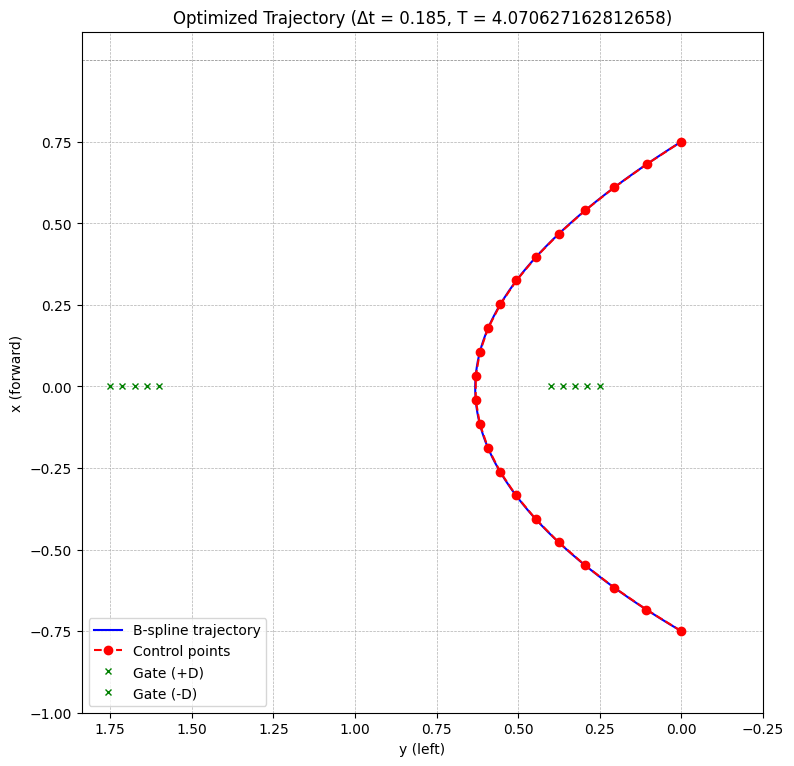

In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

# Parameters
N = 21  # control segments
D = 0.2  # distance from gate center
k = 0.6

#30, 1, 500

lambda_jerk = 30.0
lambda_gate = 1.0  # penalty for violating gate constraint
lambda_T = 1500.0
start = np.array([-0.75, 0.0])
end = np.array([0.75, 0.0])

# Optimization variables: x[1:N], y[1:N], delta_t
x_var_init = np.linspace(start[0], end[0], N+1)[1:-1]  # exclude start and end
y_var_init = 0.5*np.ones(N-1)
delta_t_init = 0.1
z_init = np.hstack((x_var_init, y_var_init, delta_t_init))

# Objective function
def objective(z):
    x_mid = z[:N - 1]
    y_mid = z[N - 1:2 * (N - 1)]
    delta_t = z[-1]

    # Reconstruct full x and y with fixed start/end
    x = np.hstack(([start[0]], x_mid, [end[0]]))
    y = np.hstack(([start[1]], y_mid, [end[1]]))

    acc_x = (x[2:] - 2 * x[1:-1] + x[:-2]) / delta_t ** 2
    acc_y = (y[2:] - 2 * y[1:-1] + y[:-2]) / delta_t ** 2

    acc = np.sum(acc_x**2 + acc_y**2)

    # 3rd-order jerk
    jerk_x = (x[3:] - 3 * x[2:-1] + 3 * x[1:-2] - x[:-3]) / delta_t**3
    jerk_y = (y[3:] - 3 * y[2:-1] + 3 * y[1:-2] - y[:-3]) / delta_t**3
    jerk = np.sum(jerk_x**2 + jerk_y**2)

    # Gate constraint penalty
    gate_pe_x, gate_pe_y = x , y #[N//2-4:N//2+4][N//2-5:N//2+5]
    gate_penalty = np.sum((gate_pe_x**2 + (gate_pe_y - 1.0 + k)**2 - D**2)**2) + np.sum((gate_pe_x**2 + (gate_pe_y - 1.0 - k)**2 - (D)**2)**2)

    return lambda_T * delta_t + lambda_jerk * (jerk+acc) + lambda_gate * gate_penalty

# Bounds: x_mid, y_mid ∈ [-5, 5]; delta_t ∈ [0.01, 1.0]
bounds = [(-5, 5)] * (2 * (N - 1)) + [(0.01, 1.0)]

# Run optimization
res = minimize(objective, z_init, bounds=bounds, method='L-BFGS-B')

x_mid = res.x[:N - 1]
y_mid = res.x[N - 1:2 * (N - 1)]
delta_t_opt = res.x[-1]

# Reconstruct full trajectory
x_opt = np.hstack(([start[0]], x_mid, [end[0]]))
y_opt = np.hstack(([start[1]], y_mid, [end[1]]))

# Optional: spline interpolation for smooth trajectory
t = np.linspace(0, 1, len(x_opt))
t_smooth = np.linspace(0, 1, 200)
spline_x = make_interp_spline(t, x_opt)(t_smooth)
spline_y = make_interp_spline(t, y_opt)(t_smooth)

# Optional: plot (for visualization if needed)
plt.figure(figsize=(8, 8))
plt.plot(spline_y, spline_x, label="B-spline trajectory", color='blue')
plt.plot(y_opt, x_opt, 'ro--', label="Control points")
plt.plot(np.linspace(1+k, 1 + k + 0.15, 5), np.zeros(5), 'gx', markersize=4, label='Gate (+D)')
plt.plot(np.linspace(1-k-0.15, 1 -k, 5), np.zeros(5), 'gx', markersize=4, label='Gate (-D)')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)
plt.title(f"Optimized Trajectory (Δt = {delta_t_opt:.3f}, T = {delta_t_opt * (N+1)})")
plt.xlabel("y (left)")
plt.ylabel("x (forward)")
plt.legend()

plt.xticks(np.arange(-0.25, 2, 0.25))
plt.yticks(np.arange(-1, 1, 0.25))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')  # 거리 비율 고정
plt.gca().invert_xaxis()

plt.tight_layout()
plt.show()

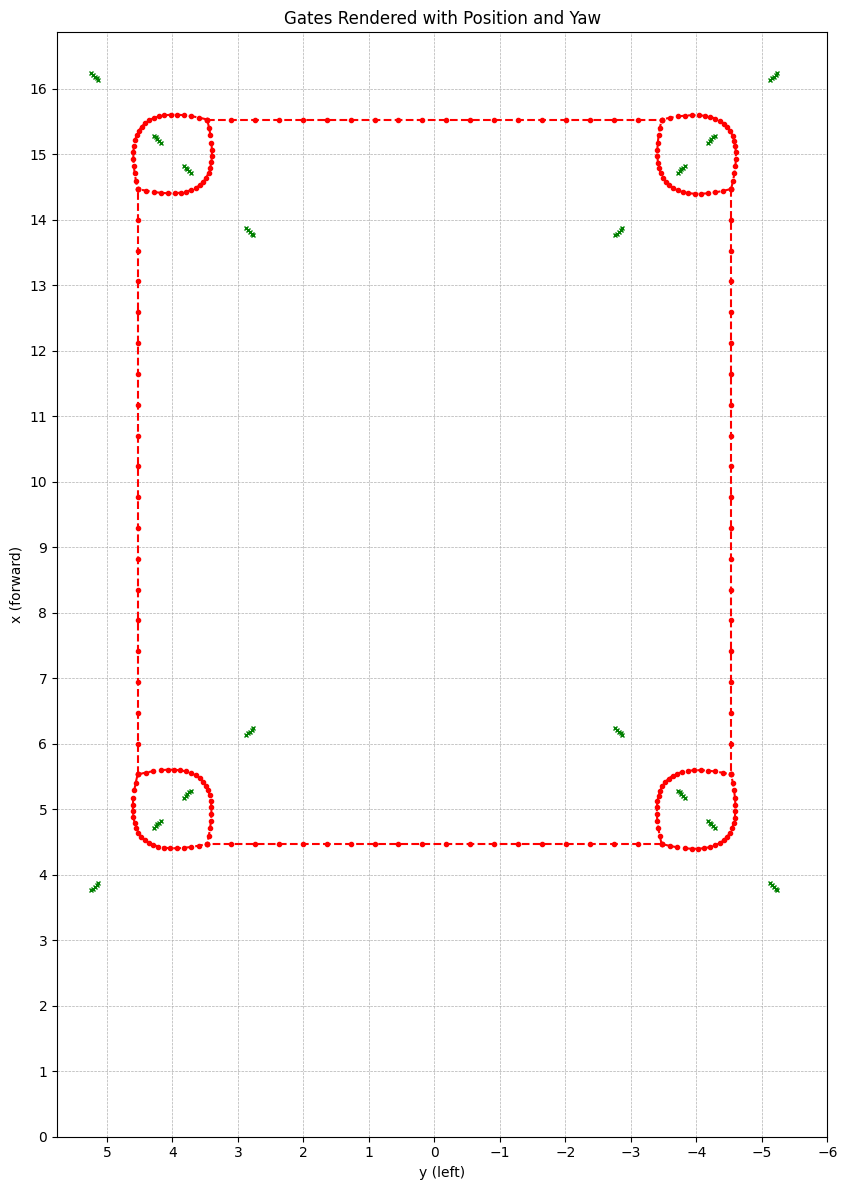

{'0': {'LEFT': array([[ 4.46966991,  4.59222164,  4.709656  ,  4.82176985,  4.92816864,
         5.02833142,  5.12171147,  5.20774562,  5.28584353,  5.35552972,
         5.41645516,  5.46840258,  5.51124617,  5.54504948,  5.57007953,
         5.58665941,  5.59515014,  5.59594837,  5.58950212,  5.57623101,
         5.55644598,  5.53033009],
       [-3.46966991, -3.44062077, -3.41861453, -3.40381648, -3.39651703,
        -3.39700449, -3.40558354, -3.4224959 , -3.44797832, -3.48226244,
        -3.52549671, -3.57769041, -3.6387141 , -3.7083841 , -3.78642977,
        -3.87243317, -3.96591686, -4.06642086, -4.17351714, -4.28676435,
        -4.40577407, -4.53033009]]), 'RIGHT': array([[ 4.46966991,  4.44062077,  4.41861453,  4.40381648,  4.39651703,
         4.39700449,  4.40558354,  4.4224959 ,  4.44797832,  4.48226244,
         4.52549671,  4.57769041,  4.6387141 ,  4.7083841 ,  4.78642977,
         4.87243317,  4.96591686,  5.06642086,  5.17351714,  5.28676435,
         5.40577407,  5.5303

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Define gate geometry: gate bar center at y = 1 ± k, height irrelevant here
k = 0.6  # half-gap offset from center
bar_width = 0.15  # width of each gate bar
bar_length = 0.15  # spread along y-axis before rotation
num_points = 5  # number of samples per gate bar

# Gate definitions: (name, x, y, z, yaw in degrees)
gate_defs = [
    ("0",  5.0, -4.0, 0.0,  -45),
    ("1", 15.0, -4.0, 0.0,   45),
    ("2", 15.0,  4.0, 0.0,  135),
    ("3",  5.0,  4.0, 0.0, -135),
]

def rotate_and_translate(x_local, y_local, yaw_deg, tx, ty):
    yaw_rad = np.radians(yaw_deg)
    cos_yaw = np.cos(yaw_rad)
    sin_yaw = np.sin(yaw_rad)
    x_global = cos_yaw * x_local - sin_yaw * y_local + tx
    y_global = sin_yaw * x_local + cos_yaw * y_local + ty
    return x_global, y_global

# Plotting
plt.figure(figsize=(12, 12))

end_points=[]

curves = {'0':{'LEFT':None, 'RIGHT':None},
          '1':{'LEFT':None, 'RIGHT':None},
          '2':{'LEFT':None, 'RIGHT':None},
          '3':{'LEFT':None, 'RIGHT':None},}

SE_point = {'0':{'S':None, 'E':None},
          '1':{'S':None, 'E':None},
          '2':{'S':None, 'E':None},
          '3':{'S':None, 'E':None},}

lines = {'0':None, '1':None, '2':None, '3':None}

for name, x, y, z, yaw in gate_defs:
    for case in [[1+k, 1+k+bar_length], [1 - k - bar_length, 1 - k], [-1 +k, -1 + k + bar_length],[-1 - k - bar_length,-1 - k],]:

        y_bar_plus = np.linspace(case[0], case[1], num_points)
        x_bar_plus = np.zeros_like(y_bar_plus)
        x_global_plus, y_global_plus = rotate_and_translate(x_bar_plus, y_bar_plus, yaw, x, y)
        plt.plot(y_global_plus, x_global_plus, 'gx', markersize=3)

    # left
    x_opt_t, y_opt_t = rotate_and_translate(x_opt, y_opt, yaw, x, y)
    plt.plot(y_opt_t, x_opt_t, 'ro--', label="Control points", markersize=3)

    curves[name]['LEFT'] = np.vstack([x_opt_t, y_opt_t])
    #right
    x_opt_t, y_opt_t = rotate_and_translate(x_opt, -y_opt, yaw, x, y)
    plt.plot(y_opt_t, x_opt_t, 'ro--', label="Control points", markersize=3)
    curves[name]['RIGHT'] = np.vstack([x_opt_t, y_opt_t])

    end_points.append([y_opt_t[0], x_opt_t[0]])
    SE_point[name]['S'] = np.vstack([x_opt_t[0], y_opt_t[0]])
    end_points.append([y_opt_t[-1], x_opt_t[-1]])
    SE_point[name]['E'] = np.vstack([x_opt_t[-1], y_opt_t[-1]])

for i in range(len(end_points)):
    s = end_points[i]
    e = end_points[(7+i)%8]

    #print(s[0], e[0])
    if s[0] == e[0]:
        y_line = s[0]*np.ones(20)
        x_line = np.linspace(s[1], e[1], 20)
        lines[str(i)] = np.vstack([x_line, y_line])
        plt.plot(y_line, x_line, 'ro--', label="inter point", markersize=3)

    if s[1] == e[1]:
        x_line = s[1]*np.ones(20)
        y_line = np.linspace(s[0], e[0], 20)
        lines[str(i)] = np.vstack([x_line, y_line])
        plt.plot(y_line, x_line, 'ro--', label="inter point", markersize=3)



# Formatting
plt.xticks(np.arange(-6, 6, 1))
plt.yticks(np.arange(0, 17, 1))
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_xaxis()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel("y (left)")
plt.ylabel("x (forward)")
plt.title("Gates Rendered with Position and Yaw")
plt.tight_layout()
plt.show()

print(curves)
print(SE_point)
print(lines)

In [20]:
initialize = np.hstack([np.linspace(0, SE_point['0']['S'][0], 10), np.linspace(0, SE_point['0']['S'][1], 10)])
initialize[2]

np.arctan2(SE_point['0']['S'][0], -SE_point['0']['S'][1])[0]/np.pi*180

curves["0"]["L"][0][0], curves["0"]["L"][1][0]

(4.4696699141100895, -3.4696699141100895)

In [33]:
curves = {'0': {'LEFT': np.array([[ 4.46966991,  4.59222164,  4.709656  ,  4.82176985,  4.92816864,
         5.02833142,  5.12171147,  5.20774562,  5.28584353,  5.35552972,
         5.41645516,  5.46840258,  5.51124617,  5.54504948,  5.57007953,
         5.58665941,  5.59515014,  5.59594837,  5.58950212,  5.57623101,
         5.55644598,  5.53033009],
       [-3.46966991, -3.44062077, -3.41861453, -3.40381648, -3.39651703,
        -3.39700449, -3.40558354, -3.4224959 , -3.44797832, -3.48226244,
        -3.52549671, -3.57769041, -3.6387141 , -3.7083841 , -3.78642977,
        -3.87243317, -3.96591686, -4.06642086, -4.17351714, -4.28676435,
        -4.40577407, -4.53033009]]), 'RIGHT': np.array([[ 4.46966991,  4.44062077,  4.41861453,  4.40381648,  4.39651703,
         4.39700449,  4.40558354,  4.4224959 ,  4.44797832,  4.48226244,
         4.52549671,  4.57769041,  4.6387141 ,  4.7083841 ,  4.78642977,
         4.87243317,  4.96591686,  5.06642086,  5.17351714,  5.28676435,
         5.40577407,  5.53033009],
       [-3.46966991, -3.59222164, -3.709656  , -3.82176985, -3.92816864,
        -4.02833142, -4.12171147, -4.20774562, -4.28584353, -4.35552972,
        -4.41645516, -4.46840258, -4.51124617, -4.54504948, -4.57007953,
        -4.58665941, -4.59515014, -4.59594837, -4.58950212, -4.57623101,
        -4.55644598, -4.53033009]])}, '1': {'LEFT': np.array([[14.46966991, 14.44062077, 14.41861453, 14.40381648, 14.39651703,
        14.39700449, 14.40558354, 14.4224959 , 14.44797832, 14.48226244,
        14.52549671, 14.57769041, 14.6387141 , 14.7083841 , 14.78642977,
        14.87243317, 14.96591686, 15.06642086, 15.17351714, 15.28676435,
        15.40577407, 15.53033009],
       [-4.53033009, -4.40777836, -4.290344  , -4.17823015, -4.07183136,
        -3.97166858, -3.87828853, -3.79225438, -3.71415647, -3.64447028,
        -3.58354484, -3.53159742, -3.48875383, -3.45495052, -3.42992047,
        -3.41334059, -3.40484986, -3.40405163, -3.41049788, -3.42376899,
        -3.44355402, -3.46966991]]), 'RIGHT': np.array([[14.46966991, 14.59222164, 14.709656  , 14.82176985, 14.92816864,
        15.02833142, 15.12171147, 15.20774562, 15.28584353, 15.35552972,
        15.41645516, 15.46840258, 15.51124617, 15.54504948, 15.57007953,
        15.58665941, 15.59515014, 15.59594837, 15.58950212, 15.57623101,
        15.55644598, 15.53033009],
       [-4.53033009, -4.55937923, -4.58138547, -4.59618352, -4.60348297,
        -4.60299551, -4.59441646, -4.5775041 , -4.55202168, -4.51773756,
        -4.47450329, -4.42230959, -4.3612859 , -4.2916159 , -4.21357023,
        -4.12756683, -4.03408314, -3.93357914, -3.82648286, -3.71323565,
        -3.59422593, -3.46966991]])}, '2': {'LEFT': np.array([[15.53033009, 15.40777836, 15.290344  , 15.17823015, 15.07183136,
        14.97166858, 14.87828853, 14.79225438, 14.71415647, 14.64447028,
        14.58354484, 14.53159742, 14.48875383, 14.45495052, 14.42992047,
        14.41334059, 14.40484986, 14.40405163, 14.41049788, 14.42376899,
        14.44355402, 14.46966991],
       [ 3.46966991,  3.44062077,  3.41861453,  3.40381648,  3.39651703,
         3.39700449,  3.40558354,  3.4224959 ,  3.44797832,  3.48226244,
         3.52549671,  3.57769041,  3.6387141 ,  3.7083841 ,  3.78642977,
         3.87243317,  3.96591686,  4.06642086,  4.17351714,  4.28676435,
         4.40577407,  4.53033009]]), 'RIGHT': np.array([[15.53033009, 15.55937923, 15.58138547, 15.59618352, 15.60348297,
        15.60299551, 15.59441646, 15.5775041 , 15.55202168, 15.51773756,
        15.47450329, 15.42230959, 15.3612859 , 15.2916159 , 15.21357023,
        15.12756683, 15.03408314, 14.93357914, 14.82648286, 14.71323565,
        14.59422593, 14.46966991],
       [ 3.46966991,  3.59222164,  3.709656  ,  3.82176985,  3.92816864,
         4.02833142,  4.12171147,  4.20774562,  4.28584353,  4.35552972,
         4.41645516,  4.46840258,  4.51124617,  4.54504948,  4.57007953,
         4.58665941,  4.59515014,  4.59594837,  4.58950212,  4.57623101,
         4.55644598,  4.53033009]])}, '3': {'LEFT': np.array([[5.53033009, 5.55937923, 5.58138547, 5.59618352, 5.60348297,
        5.60299551, 5.59441646, 5.5775041 , 5.55202168, 5.51773756,
        5.47450329, 5.42230959, 5.3612859 , 5.2916159 , 5.21357023,
        5.12756683, 5.03408314, 4.93357914, 4.82648286, 4.71323565,
        4.59422593, 4.46966991],
       [4.53033009, 4.40777836, 4.290344  , 4.17823015, 4.07183136,
        3.97166858, 3.87828853, 3.79225438, 3.71415647, 3.64447028,
        3.58354484, 3.53159742, 3.48875383, 3.45495052, 3.42992047,
        3.41334059, 3.40484986, 3.40405163, 3.41049788, 3.42376899,
        3.44355402, 3.46966991]]), 'RIGHT': np.array([[5.53033009, 5.40777836, 5.290344  , 5.17823015, 5.07183136,
        4.97166858, 4.87828853, 4.79225438, 4.71415647, 4.64447028,
        4.58354484, 4.53159742, 4.48875383, 4.45495052, 4.42992047,
        4.41334059, 4.40484986, 4.40405163, 4.41049788, 4.42376899,
        4.44355402, 4.46966991],
       [4.53033009, 4.55937923, 4.58138547, 4.59618352, 4.60348297,
        4.60299551, 4.59441646, 4.5775041 , 4.55202168, 4.51773756,
        4.47450329, 4.42230959, 4.3612859 , 4.2916159 , 4.21357023,
        4.12756683, 4.03408314, 3.93357914, 3.82648286, 3.71323565,
        3.59422593, 3.46966991]])}}

SE_point = {
    0: {'S': np.array([[ 4.46966991],
       [-3.46966991]]), 'E': np.array([[ 5.53033009],
       [-4.53033009]])}, 
    1: {'S': np.array([[14.46966991],
       [-4.53033009]]), 'E': np.array([[15.53033009],
       [-3.46966991]])}, 
    2: {'S': np.array([[15.53033009],
       [ 3.46966991]]), 'E': np.array([[14.46966991],
       [ 4.53033009]])}, 
    3: {'S': np.array([[5.53033009],
       [4.53033009]]), 'E': np.array([[4.46966991],
       [3.46966991]])}}


SE_point[0]["S"][1][0]

np.hstack([np.linspace(SE_point[3]['E'][0], SE_point[0]['S'][0], 20), np.linspace(SE_point[3]['E'][1], SE_point[0]['S'][1], 20)])[0][0]

4.46966991